*Ce billet a été écrit à l'aide d'un notebook Jupyter. Son contenu est sous licence BSD. Une vue statique de ce notebook peut être consultée et téléchargée ici : [20170502_ElectionsTour1.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170502_ElectionsTour1.ipynb).*

A l'occasion du premier tour des élections présidentielles 2017, je vous propose dans ce billet de produire des cartes qui permettent de visualiser les résultats des 11 candidats sur le territoire français. 

Il existe de nombreuses manières différentes de visualiser les données issues du vote. Afin de commencer cette exploration, nous allons tout d'abord essayer de reproduire une visualisation publiée sur le [site du monde](http://www.lemonde.fr/data/france/presidentielle-2017/), qui affiche les résultats par département.

# Par département

Dans [un billet précédent](http://flothesof.github.io/bus-departure-map-Paris.html), j'avais utilisé des fichiers au [format shapefile](https://en.wikipedia.org/wiki/Shapefile) pour dessiner des départements français sur une carte. Nous allons réutiliser la procédure pour faire une carte de ce découpage administratif. Cette fois-ci le fichier shapefile provient du [site de l'IGN](https://wxs-telechargement.ign.fr/oikr5jryiph0iwhw36053ptm/telechargement/inspire/GEOFLA_THEME-DEPARTEMENTS_2016$GEOFLA_2-2_DEPARTEMENT_SHP_LAMB93_FXX_2016-06-28/file/GEOFLA_2-2_DEPARTEMENT_SHP_LAMB93_FXX_2016-06-28.7z).

Nous allons tout d'abord lire les données contenues dans le fichier shapefile pour la France.

In [1]:
import shapefile

In [2]:
r = shapefile.Reader(r"files/departement_shapes/DEPARTEMENT.shp")
shapes = r.shapes()
records = r.records()
fields = r.fields

On va construire une dataframe pandas avec ces objets.

In [3]:
import pandas as pd

In [4]:
df = pd.DataFrame(records, columns=[f[0] for f in fields[1:]])

In [5]:
df.head()

,ID_GEOFLA,CODE_DEPT,NOM_DEPT,CODE_CHF,NOM_CHF,X_CHF_LIEU,Y_CHF_LIEU,X_CENTROID,Y_CENTROID,CODE_REG,NOM_REG
0,DEPARTEM0000000000000001,39,JURA,300,LONS-LE-SAUNIER,895198,6622537,886172,6641548,27,BOURGOGNE-FRANCHE-COMTE
1,DEPARTEM0000000000000002,42,LOIRE,218,SAINT-ETIENNE,808646,6482549,795655,6521581,84,AUVERGNE-RHONE-ALPES
2,DEPARTEM0000000000000003,76,SEINE-MARITIME,540,ROUEN,562355,6928721,550942,6952842,28,NORMANDIE
3,DEPARTEM0000000000000004,89,YONNE,024,AUXERRE,742447,6744261,748211,6750855,27,BOURGOGNE-FRANCHE-COMTE
4,DEPARTEM0000000000000005,68,HAUT-RHIN,066,COLMAR,1024125,6784581,1016174,6763894,44,ALSACE-CHAMPAGNE-ARDENNE-LORRAINE


On va maintenant dessiner les départements dont les informations sont contenues dans ce fichier shapefile.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
from matplotlib.collections import LineCollection

In [7]:
def draw_departements(ax, records, shapes):
    "Draws a map of the départements."
    for record, shape in zip(records, shapes):
        lons, lats = zip(*shape.points)
        data = np.array([lons, lats]).T

        if len(shape.parts) == 1:
            segs = [data,]
        else:
            segs = []
            for i in range(1,len(shape.parts)):
                index = shape.parts[i-1]
                index2 = shape.parts[i]
                segs.append(data[index:index2])
            segs.append(data[index2:])

        lines = LineCollection(segs,antialiaseds=(1,))
        lines.set_edgecolors('k')
        lines.set_linewidth(0.3)
        ax.add_collection(lines)

(71326.0, 1328512.0, 6008968.0, 7159443.0)

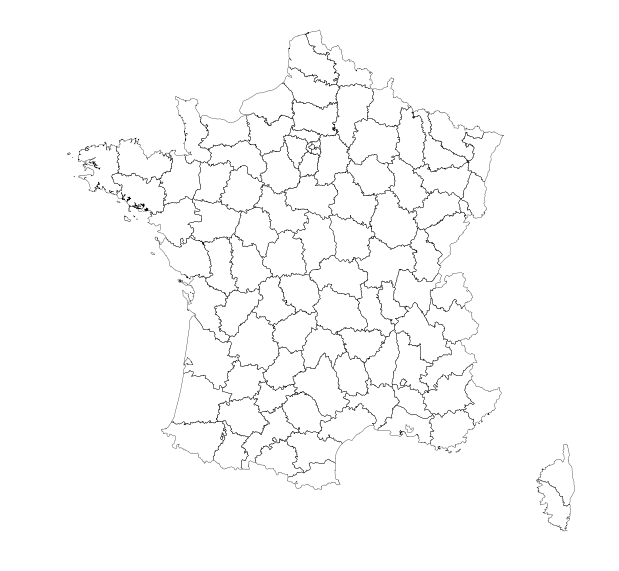

In [8]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
draw_departements(ax, records, shapes)
        
xmin, xmax = df['X_CHF_LIEU'].min(), df['X_CHF_LIEU'].max()
ymin, ymax = df['Y_CHF_LIEU'].min(), df['Y_CHF_LIEU'].max()
plt.xlim(xmin - 100000, xmax + 100000)
plt.ylim(ymin - 100000, ymax + 100000)
plt.axis('off')

A partir de ce graphique, on va maintenant colorier les départements avec la couleur du candidat dominant. Pour faire ceci, il faut aller chercher les résultats sur le site du ministère de l'intérieur: <http://elections.interieur.gouv.fr/presidentielle-2017/index.html>. De manière assez intéressante, le site du ministère affiche directement les coordonnées des départements dans le code source de sa page et y associe les liens vers les pages de résultats, que l'on peut en extraire.

In [9]:
from bs4 import BeautifulSoup
import requests

In [10]:
soup = BeautifulSoup(requests.get("http://elections.interieur.gouv.fr/presidentielle-2017/index.html").text, 'html.parser')

In [11]:
map_tag = soup.find('map')

In [12]:
area_tags = map_tag.find_all('area')

In [13]:
links = [tag.attrs['href'] for tag in area_tags]

In [14]:
unique_links = set(links)

On peut maintenant aller extraire les données pour chaque candidat à partir de ces liens individuels.

In [15]:
url = "http://elections.interieur.gouv.fr/presidentielle-2017/024/018/index.html"

In [16]:
def extract_candidate_votes(url):
    "Extracts votes for all candidates from a given url."
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    dept = soup.find(class_='span12 pub-fil-ariane').find_all('a')[-1].text
    table = soup.find('tbody')
    results = {}
    for row in table.find_all('tr'):
        results[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))
    return dept, results

Testons cette fonction :

In [17]:
extract_candidate_votes(url)

('Cher (18)',
 {'M. Benoît HAMON': 9157,
  'M. Emmanuel MACRON': 38076,
  'M. François ASSELINEAU': 1479,
  'M. François FILLON': 32967,
  'M. Jacques CHEMINADE': 345,
  'M. Jean LASSALLE': 1925,
  'M. Jean-Luc MÉLENCHON': 33694,
  'M. Nicolas DUPONT-AIGNAN': 9554,
  'M. Philippe POUTOU': 2106,
  'Mme Marine LE PEN': 41753,
  'Mme Nathalie ARTHAUD': 1630})

Nous pouvons maintenant écrire une boucle pour extraire l'information pour tous les départements.

In [18]:
depts = []
results = []
for link in unique_links:
    dept, result = extract_candidate_votes("http://elections.interieur.gouv.fr/presidentielle-2017/" + link) 
    depts.append(dept)
    results.append(result)

A l'aide de cette information, nous pouvons réconcilier les données géographique et les résultats du vote.

In [19]:
df_votes = pd.DataFrame(results, index=depts)

In [20]:
df_votes.tail()

,M. Benoît HAMON,M. Emmanuel MACRON,M. François ASSELINEAU,M. François FILLON,M. Jacques CHEMINADE,M. Jean LASSALLE,M. Jean-Luc MÉLENCHON,M. Nicolas DUPONT-AIGNAN,M. Philippe POUTOU,Mme Marine LE PEN,Mme Nathalie ARTHAUD
Lozère (48),2733,10463,354,10986,93,1764,9483,2197,683,9097,294
Jura (39),7589,31896,1330,28373,285,1994,30331,8533,1980,36110,1148
Indre (36),7786,27301,1098,25476,298,1728,24938,7177,1757,31985,1390
Manche (50),19238,74683,2048,64909,623,2520,51026,17052,4134,61620,2593
Alpes-Maritimes (06),21067,111953,6067,161036,939,5262,87941,25175,3622,163141,1729


On peut trier ce tableau par nombre de votants total dans le département.

In [21]:
vote_sum = df_votes.sum(axis=1).sort_values(ascending=True)

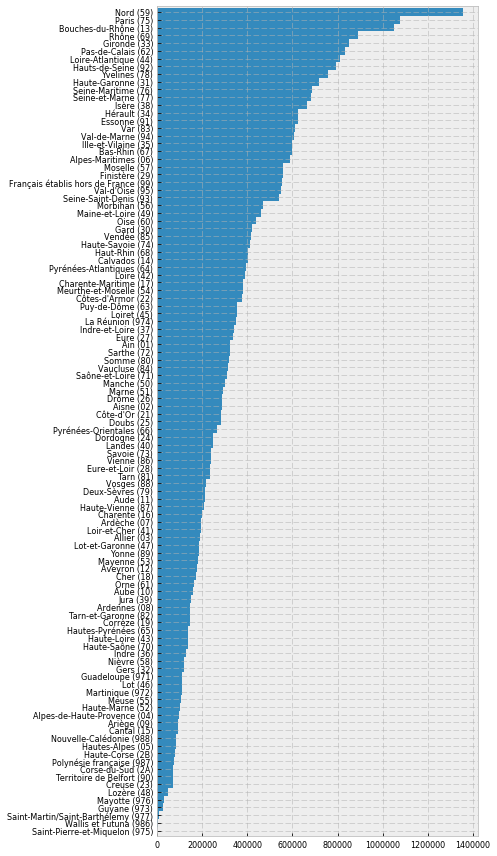

In [22]:
fig, ax = plt.subplots(figsize=(7, 12))
vote_sum.plot.barh(ax=ax, fontsize=8, width=1)
plt.tight_layout()

In [23]:
df_votes['total'] = vote_sum

In [24]:
df_votes = df_votes.sort_values(by='total', ascending=True)

In [25]:
df_votes = df_votes.drop('total', 1)

Ceci nous permet par exemple de faire le tableau suivant :

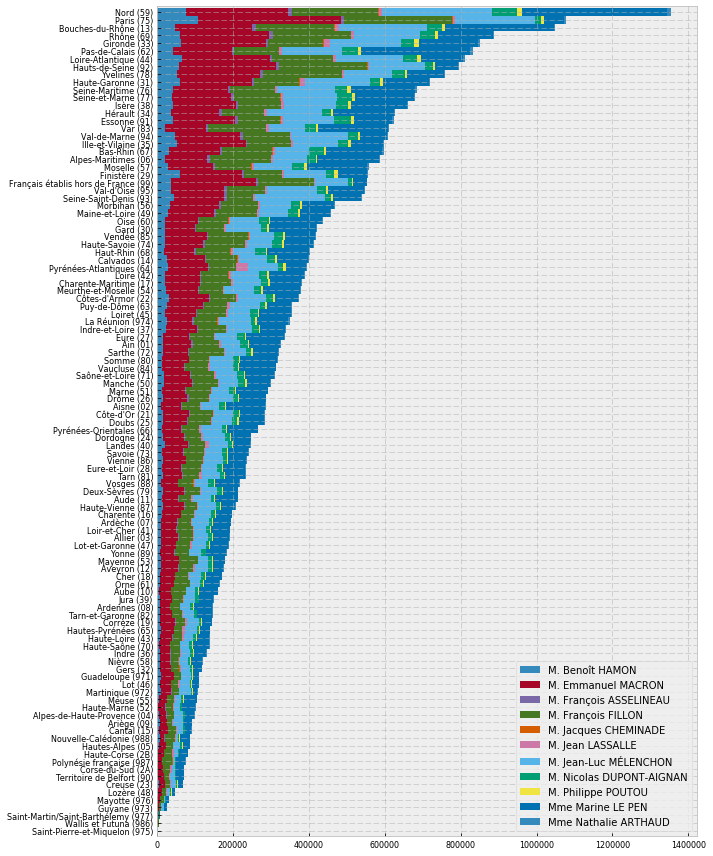

In [26]:
fig, ax = plt.subplots(figsize=(10, 12))
df_votes.plot.barh(ax=ax, stacked=True, fontsize=8, width=1)
plt.tight_layout()

Enfin, on peut combiner les informations géographiques et aboutir à la représentation de la carte colorée obtenue par Le Monde :

In [27]:
candidate_colors = np.linspace(0, 1, 20)

In [28]:
cmap = plt.get_cmap('Vega20_r')

In [30]:
import matplotlib as mpl

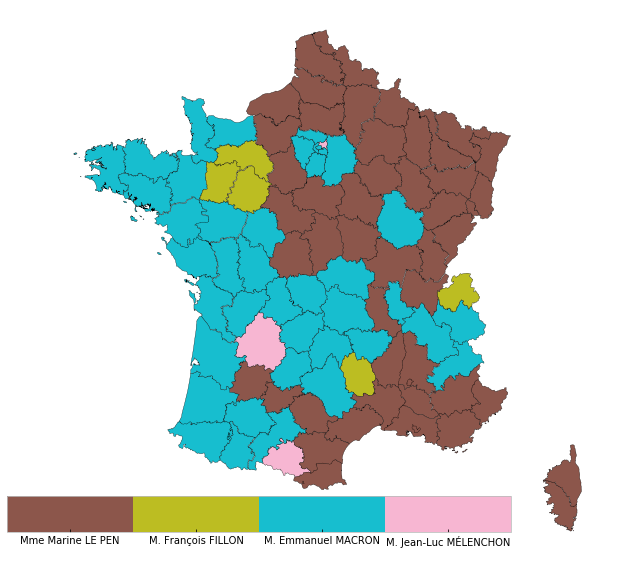

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
idxs = []
for record, shape, code_dpt in zip(records, shapes, df['CODE_DEPT']):
    lons, lats = zip(*shape.points)
    data = np.array([lons, lats]).T

    if len(shape.parts) == 1:
        segs = [data,]
    else:
        segs = []
        for i in range(1,len(shape.parts)):
            index = shape.parts[i-1]
            index2 = shape.parts[i]
            segs.append(data[index:index2])
        segs.append(data[index2:])

    lines = LineCollection(segs, antialiaseds=(1,))
    lines.set_edgecolors('k')
    lines.set_linewidth(0.3)
    values = df_votes[df_votes.index.str.contains("({})".format(code_dpt), regex=False)].values
    idx = np.argmax(values)
    idxs.append(idx)
    facecolor = cmap(candidate_colors[idx])
    lines.set_facecolor(facecolor)
    ax.add_collection(lines)
        
        
xmin, xmax = df['X_CHF_LIEU'].min(), df['X_CHF_LIEU'].max()
ymin, ymax = df['Y_CHF_LIEU'].min(), df['Y_CHF_LIEU'].max()
plt.xlim(xmin - 100000, xmax + 100000)
plt.ylim(ymin - 100000, ymax + 100000)
plt.axis('off')

ax_cbar = fig.add_axes([0.05, 0.15, 0.7, 0.05])
cbar_cmap = mpl.colors.ListedColormap(np.array([cmap(candidate_colors[i]) for i in set(idxs)]))
bounds = list(range(len(set(idxs)) + 1))
norm = mpl.colors.BoundaryNorm(bounds, cbar_cmap.N)
cb = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cbar_cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.array(bounds) + 0.5,
                                spacing='uniform',
                                orientation='horizontal')
cb.ax.set_xticklabels([df_votes.columns[i] for i in set(idxs)]);  # horizontal colorbar

On peut reprendre la carte ci-dessus et introduire de la transparence pour marquer l'écart au candidat arrivé en premier pour se rendre compte des autres forces politiques en présence :

In [33]:
mapping_func = lambda z: 1 - (1 - z)**2

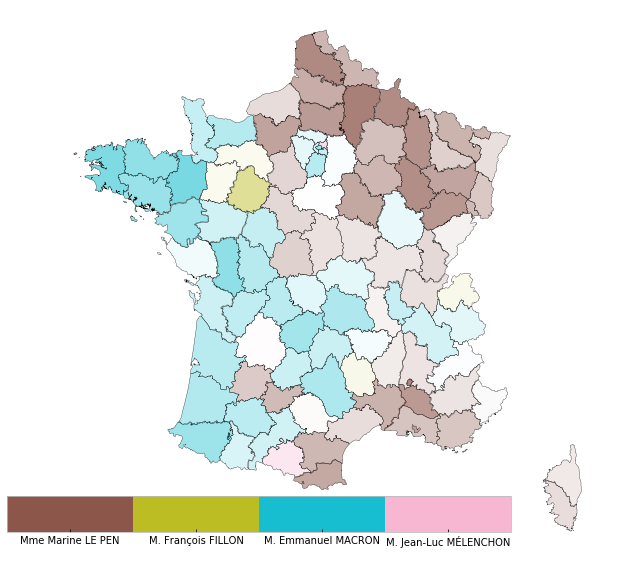

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
idxs = []
for record, shape, code_dpt in zip(records, shapes, df['CODE_DEPT']):
    lons, lats = zip(*shape.points)
    data = np.array([lons, lats]).T

    if len(shape.parts) == 1:
        segs = [data,]
    else:
        segs = []
        for i in range(1,len(shape.parts)):
            index = shape.parts[i-1]
            index2 = shape.parts[i]
            segs.append(data[index:index2])
        segs.append(data[index2:])

    lines = LineCollection(segs, antialiaseds=(1,))
    lines.set_edgecolors('k')
    lines.set_linewidth(0.3)
    values = df_votes[df_votes.index.str.contains("({})".format(code_dpt), regex=False)].values
    idx = np.argmax(values)
    idxs.append(idx)
    facecolor = np.array(cmap(candidate_colors[idx]))
    facecolor[3] = mapping_func((values[0, idx] - np.sort(values.ravel())[-2]) / values[0, idx])
    lines.set_facecolor(facecolor)
    ax.add_collection(lines)
        
        
xmin, xmax = df['X_CHF_LIEU'].min(), df['X_CHF_LIEU'].max()
ymin, ymax = df['Y_CHF_LIEU'].min(), df['Y_CHF_LIEU'].max()
plt.xlim(xmin - 100000, xmax + 100000)
plt.ylim(ymin - 100000, ymax + 100000)
plt.axis('off')

ax_cbar = fig.add_axes([0.05, 0.15, 0.7, 0.05])
cbar_cmap = mpl.colors.ListedColormap(np.array([cmap(candidate_colors[i]) for i in set(idxs)]))
bounds = list(range(len(set(idxs)) + 1))
norm = mpl.colors.BoundaryNorm(bounds, cbar_cmap.N)
cb = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cbar_cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.array(bounds) + 0.5,
                                spacing='uniform',
                                orientation='horizontal')
cb.ax.set_xticklabels([df_votes.columns[i] for i in set(idxs)]);  # horizontal colorbar

Sur la carte ci-dessus, les départements plutôt blancs ont été gagnés avec moins d'avance relative que que ceux qui sont foncés. On peut noter ici l'influence locale de François Fillon dans la Sarthe, celle d'Emmanuel Macron en Bretagne ou encore de Marine Le Pen dans l'Est.  

# Par candidat 

Un deuxième axe d'affichage consiste à dessiner le nombre d'électeur obtenu pour chaque candidat en fonction du département. On utilise la valeur de transparence pour indiquer si le nombre d'électeurs par département est proche du nombre d'électeur maximum par département.

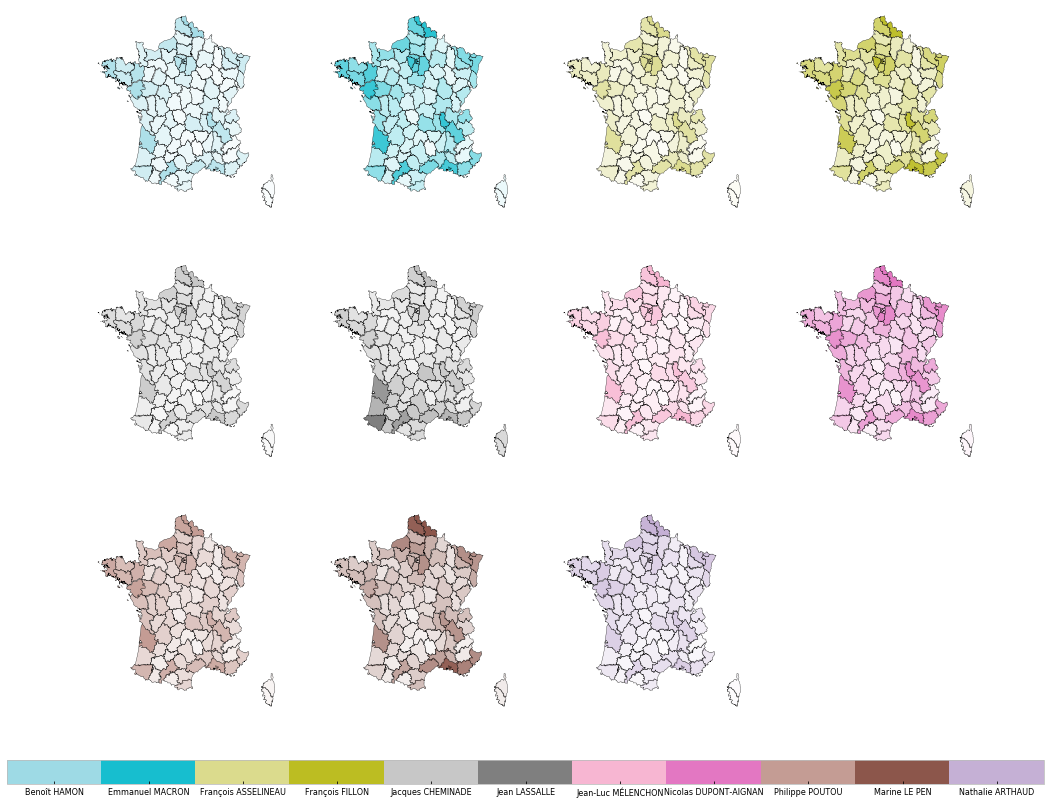

In [36]:
fig = plt.figure(figsize=(16, 13))
for candidate_idx in np.arange(df_votes.columns.size):
    ax = plt.subplot(3, 4, candidate_idx+1)

    for record, shape, code_dpt in zip(records, shapes, df['CODE_DEPT']):
        lons, lats = zip(*shape.points)
        data = np.array([lons, lats]).T

        if len(shape.parts) == 1:
            segs = [data,]
        else:
            segs = []
            for i in range(1,len(shape.parts)):
                index = shape.parts[i-1]
                index2 = shape.parts[i]
                segs.append(data[index:index2])
            segs.append(data[index2:])

        lines = LineCollection(segs, antialiaseds=(1,))
        lines.set_edgecolors('k')
        lines.set_linewidth(0.3)
        values = df_votes[df_votes.index.str.contains("({})".format(code_dpt), regex=False)].values

        facecolor = np.array(cmap(candidate_colors[candidate_idx]))
        facecolor[3] = mapping_func(float(values[0, candidate_idx]) / df_votes.max(axis=0)[df_votes.columns[candidate_idx]])
        lines.set_facecolor(facecolor)
        ax.add_collection(lines)


    xmin, xmax = df['X_CHF_LIEU'].min(), df['X_CHF_LIEU'].max()
    ymin, ymax = df['Y_CHF_LIEU'].min(), df['Y_CHF_LIEU'].max()
    ax.set_xlim(xmin - 100000, xmax + 100000)
    ax.set_ylim(ymin - 100000, ymax + 100000)
    ax.axis('off')

ax_cbar = fig.add_axes([0.05, 0.05, 0.9, 0.025])
cbar_colors = np.array([cmap(candidate_colors[i]) for i in np.arange(df_votes.columns.size)])
cbar_cmap = mpl.colors.ListedColormap(cbar_colors)
bounds = np.arange(cbar_colors.shape[0] + 1)
norm = mpl.colors.BoundaryNorm(bounds, cbar_cmap.N)
cb = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cbar_cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.array(bounds) + 0.5,
                                spacing='uniform',
                                orientation='horizontal')
cb.ax.tick_params(labelsize=8) 
cb.ax.set_xticklabels(df_votes.columns.str.extract('^(?:M. |Mme )(.*)', expand=False));  

Sur le graphique ci-dessus, on peut voir apparaître certains phénomènes locaux, comme par exemple le succès de Jean Lassalle dans les Pyrénées, mais il est difficile de distinguer les grandes tendances. 

Si l'on reprend le graphique précédent mais que l'on normalise cette fois-ci en termes de données d'électeur maximum dans tout le département, on obtient :

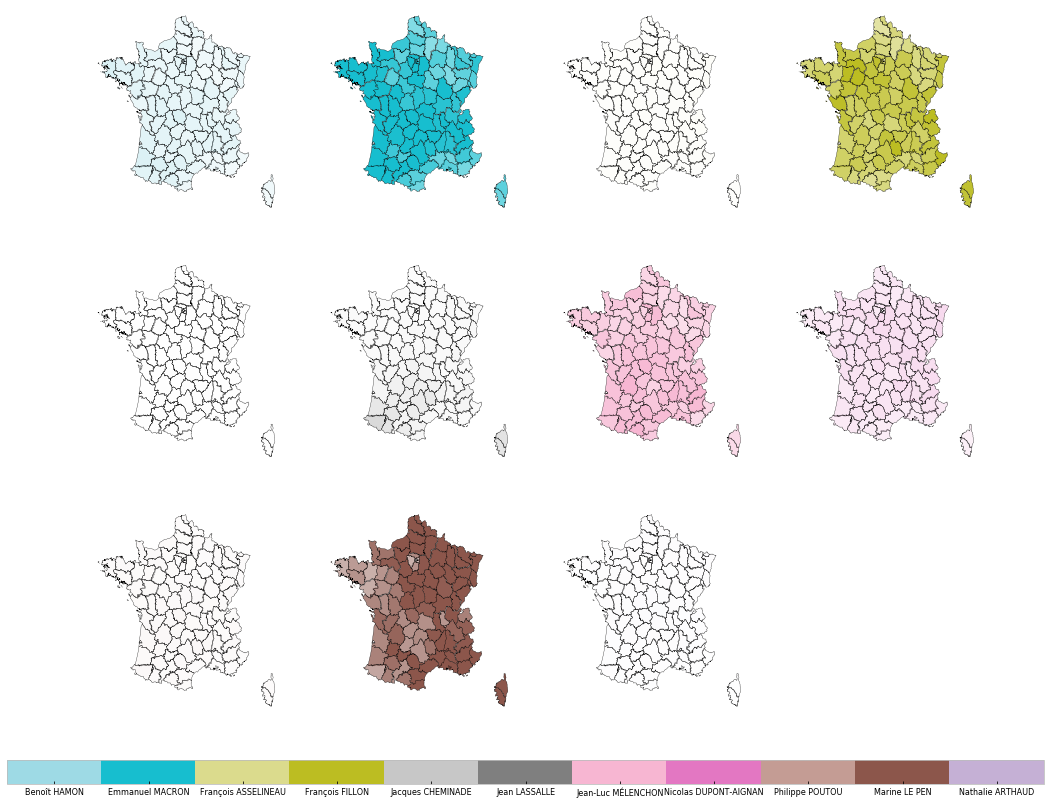

In [37]:
fig = plt.figure(figsize=(16, 13))
for candidate_idx in np.arange(df_votes.columns.size):
    ax = plt.subplot(3, 4, candidate_idx+1)

    for record, shape, code_dpt in zip(records, shapes, df['CODE_DEPT']):
        lons, lats = zip(*shape.points)
        data = np.array([lons, lats]).T

        if len(shape.parts) == 1:
            segs = [data,]
        else:
            segs = []
            for i in range(1,len(shape.parts)):
                index = shape.parts[i-1]
                index2 = shape.parts[i]
                segs.append(data[index:index2])
            segs.append(data[index2:])

        lines = LineCollection(segs, antialiaseds=(1,))
        lines.set_edgecolors('k')
        lines.set_linewidth(0.3)
        values = df_votes[df_votes.index.str.contains("({})".format(code_dpt), regex=False)].values

        facecolor = np.array(cmap(candidate_colors[candidate_idx]))
        facecolor[3] = (float(values[0, candidate_idx]) / values.max())
        lines.set_facecolor(facecolor)
        ax.add_collection(lines)


    xmin, xmax = df['X_CHF_LIEU'].min(), df['X_CHF_LIEU'].max()
    ymin, ymax = df['Y_CHF_LIEU'].min(), df['Y_CHF_LIEU'].max()
    ax.set_xlim(xmin - 100000, xmax + 100000)
    ax.set_ylim(ymin - 100000, ymax + 100000)
    ax.axis('off')

ax_cbar = fig.add_axes([0.05, 0.05, 0.9, 0.025])
cbar_colors = np.array([cmap(candidate_colors[i]) for i in np.arange(df_votes.columns.size)])
cbar_cmap = mpl.colors.ListedColormap(cbar_colors)
bounds = np.arange(cbar_colors.shape[0] + 1)
norm = mpl.colors.BoundaryNorm(bounds, cbar_cmap.N)
cb = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cbar_cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.array(bounds) + 0.5,
                                spacing='uniform',
                                orientation='horizontal')
cb.ax.tick_params(labelsize=8) 
cb.ax.set_xticklabels(df_votes.columns.str.extract('^(?:M. |Mme )(.*)', expand=False));  

La carte ci-dessus met en valeur une chose assez intéressante : la France est partagée de manière homogène à l'échelle des départements entre quatre ou cinq "grands" candidats. 

# Conclusions 

Dans ce billet, nous avons vu comment l'on pouvait combiner les informations géographiques liées aux départements et les résultats du premier tour de l'élection présidentielle afin de dessiner quelques cartes. Il en ressort qu'il est assez difficile d'en tirer des interprétations pertinents. Si vous avez des suggestions d'autres cartes à dessiner, n'hésitez pas à m'en faire part dans les commentaires.